In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install foolbox
import foolbox 
import os
import math
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import torch.optim as optim

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
Defaulting to user installation because normal site-packages is not writeable
  Using cached foolbox-3.3.1.tar.gz (1.6 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  ERROR: Command errored out with exit status 1:
   command: /usr/bin/python /usr/local/lib/python2.7/dist-packages/pip/_vendor/pep517/_in_process.py get_requires_for_build_wheel /tmp/tmpRUgaTh
       cwd: /tmp/pip-install-7NeM8L/foolbox
  Complete output (18 lines):
  Traceback (most recent call last):
    File "/usr/local/lib/python2.7/dist-packages/pip/_vendor/pep517/_in_process.py", line 280, i

/usr/local/lib/python3.6/dist-packages/numba/core/errors.py:149: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
torch.cuda.set_device('cuda:1')

In [3]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device1=torch.device('cpu')
print(device)

cuda


In [4]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4845, 0.4903, 0.4508],[0.2135, 0.1970, 0.1911])
])

In [5]:
train_set=torchvision.datasets.ImageFolder(root="/home/ar_1/ucm_train/", transform=transformer)
valid_set=torchvision.datasets.ImageFolder(root="/home/ar_1/ucm_valid/", transform=transformer)

batch_size_train=8
batch_size_valid=8
train_loader=DataLoader(train_set, batch_size=batch_size_train, shuffle=True)
valid_loader=DataLoader(valid_set, batch_size_valid, shuffle=True)

In [6]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=21):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model

In [7]:
model=resnet50().to(device)

In [8]:
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
criterion=nn.CrossEntropyLoss()

In [9]:
train_count=len(train_set)
valid_count=len(valid_set)

In [ ]:
best_accuracy=0.0
num_epochs=100

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    valid_loss=0.0
    valid_accuracy=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count

    model.eval()
    
    for data, target in valid_loader:
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      loss = criterion(output, target)
        
      # update-average-validation-loss 
      valid_loss += loss.item() * data.size(0)

      _,prediction=torch.max(output.data,1)
      valid_accuracy+=int(torch.sum(prediction==target.data))
      
    
    valid_accuracy=valid_accuracy/valid_count
    valid_loss=valid_loss/valid_count
       
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+ ' Valid Loss:'+str(valid_loss)+' Valid Accuracy:'+str(valid_accuracy))

    if(valid_accuracy>best_accuracy):
      torch.save(model.state_dict(), '/content/drive/MyDrive/resnet50/model.pth')
      best_accuracy=valid_accuracy
      print("Best accuracy: ", best_accuracy)


In [10]:
model.load_state_dict(torch.load("/home/ar_1/weight/resnet50.pth"))

<All keys matched successfully>

In [ ]:
# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        

    print('Test Accuracy of the model: {} '.format(correct / total))


Test Accuracy of the model: 0.7231503579952268 


In [16]:
model=model.eval()

In [17]:
bounds = (0, 1)
fmodel = foolbox.PyTorchModel(model, bounds=bounds,device='cuda:1')

In [18]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
dir="/home/ar_1/ucm_train/"
classes = os.listdir(dir)
classes.sort()

0.7231503427028656


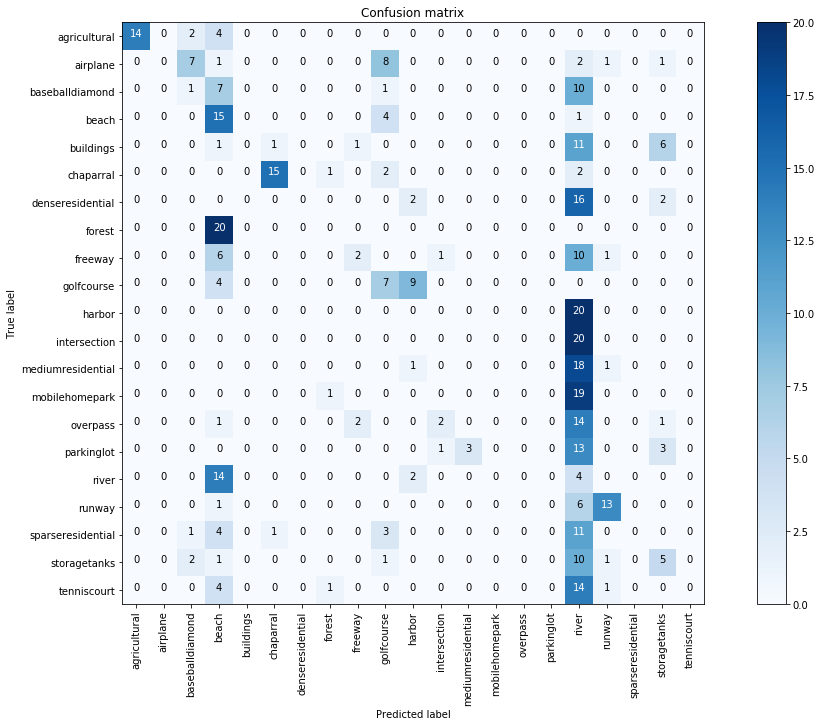

In [20]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2ContrastReductionAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.7207637131214142


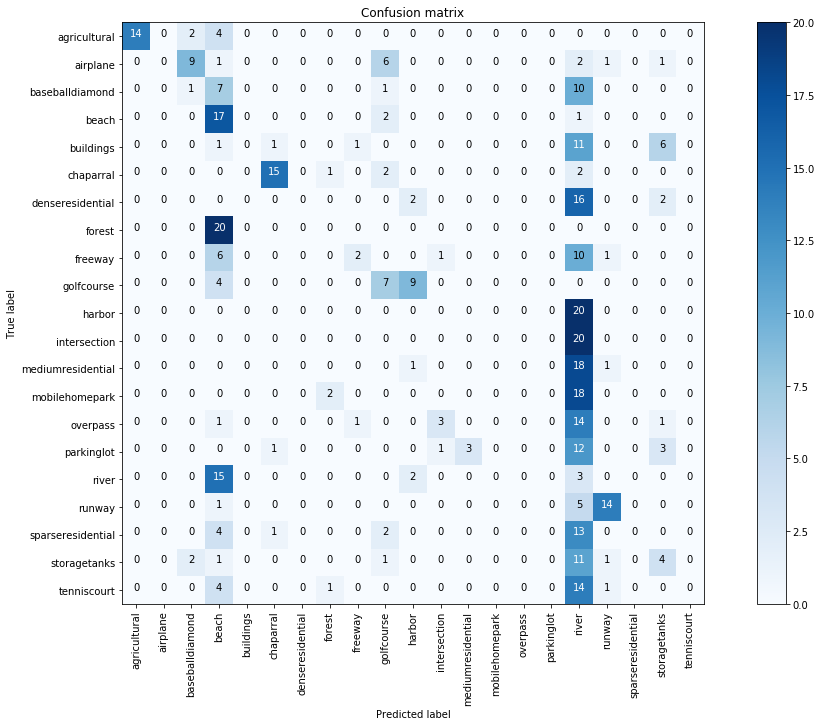

In [21]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.VirtualAdversarialAttack(steps=1)

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.6968973577022552


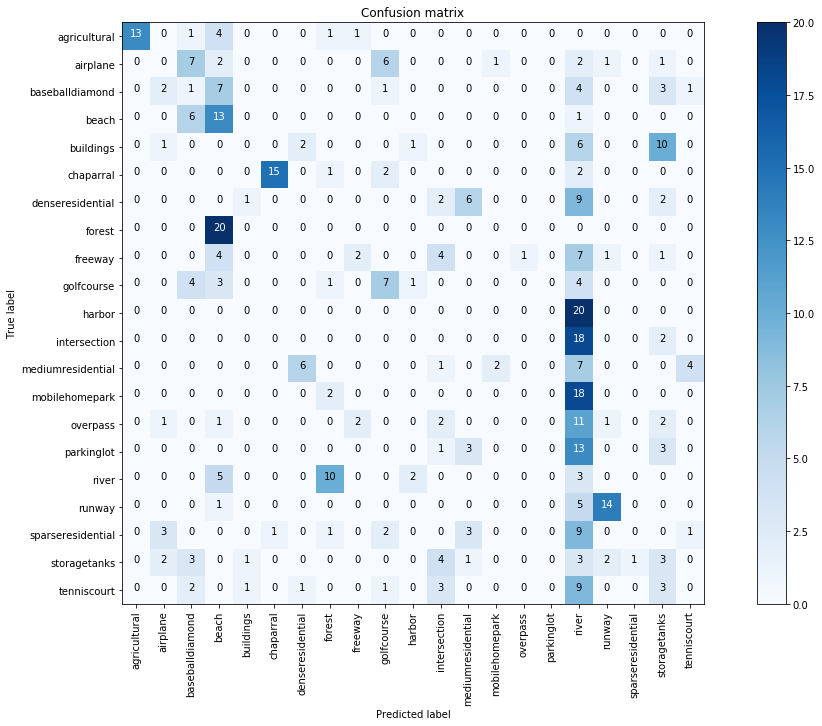

In [22]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.DDNAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.725536972284317


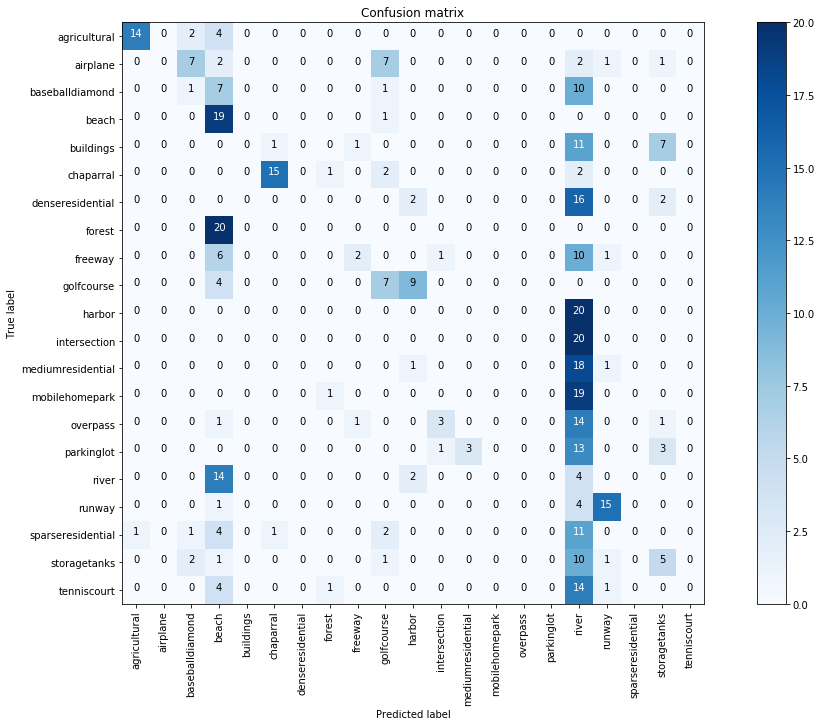

In [23]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2ProjectedGradientDescentAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 
labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.09546536207199097


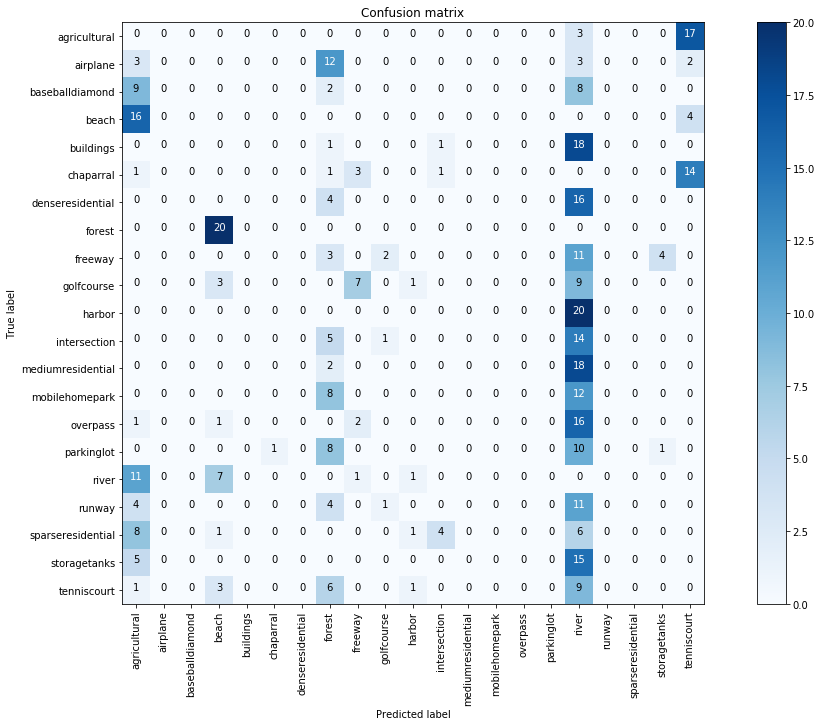

In [24]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfProjectedGradientDescentAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.7159904539585114


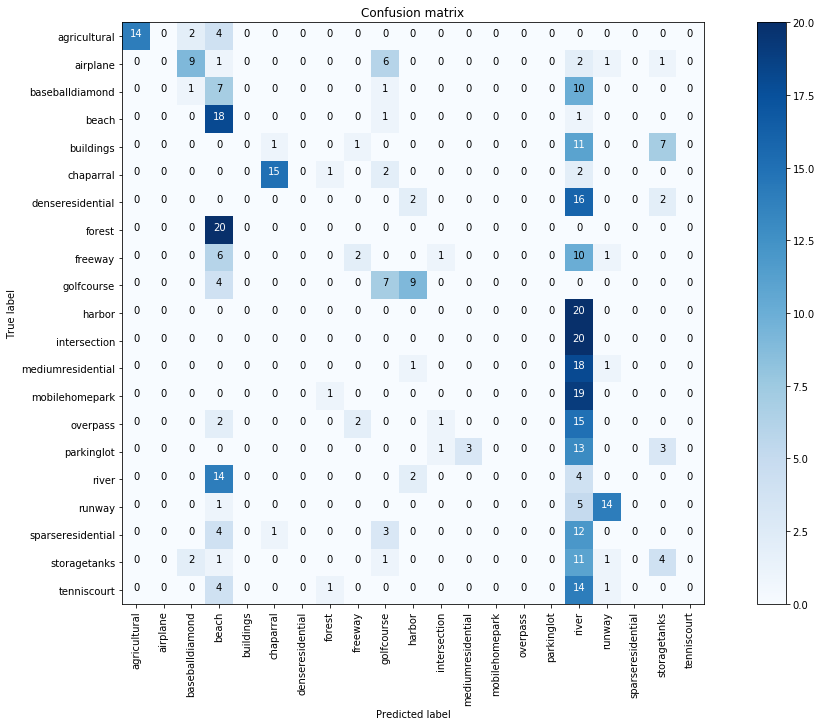

In [25]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2BasicIterativeAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 
labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.10262525081634521


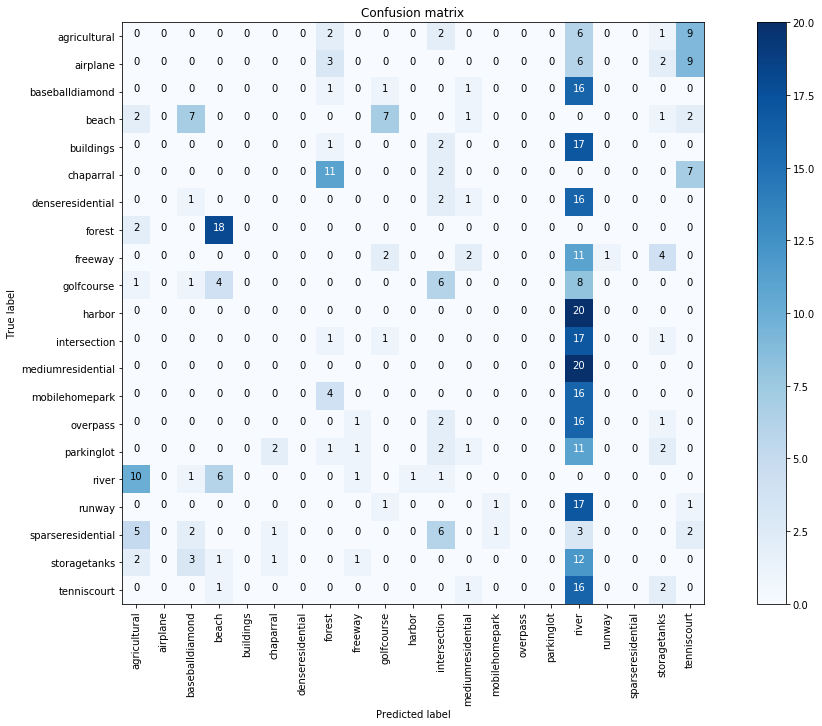

In [26]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfBasicIterativeAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 
labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.7136037945747375


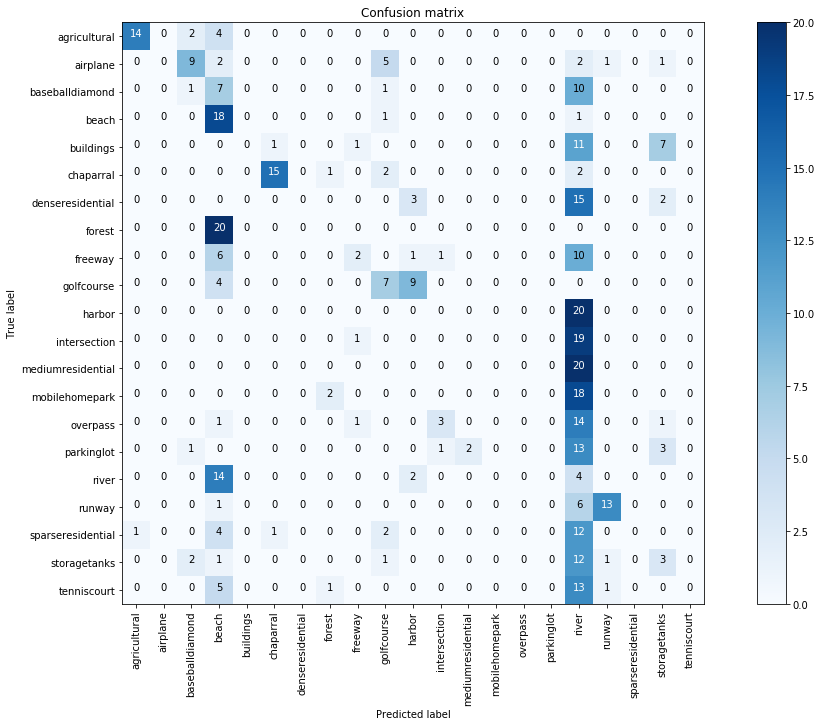

In [27]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2FastGradientAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.13603812456130981


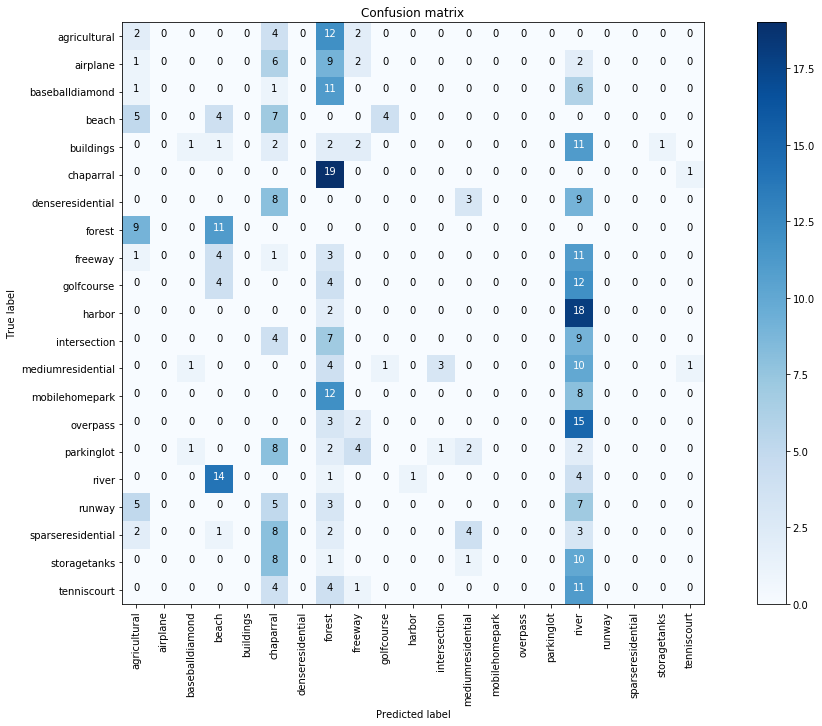

In [28]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfFastGradientAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 
labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.7088305354118347


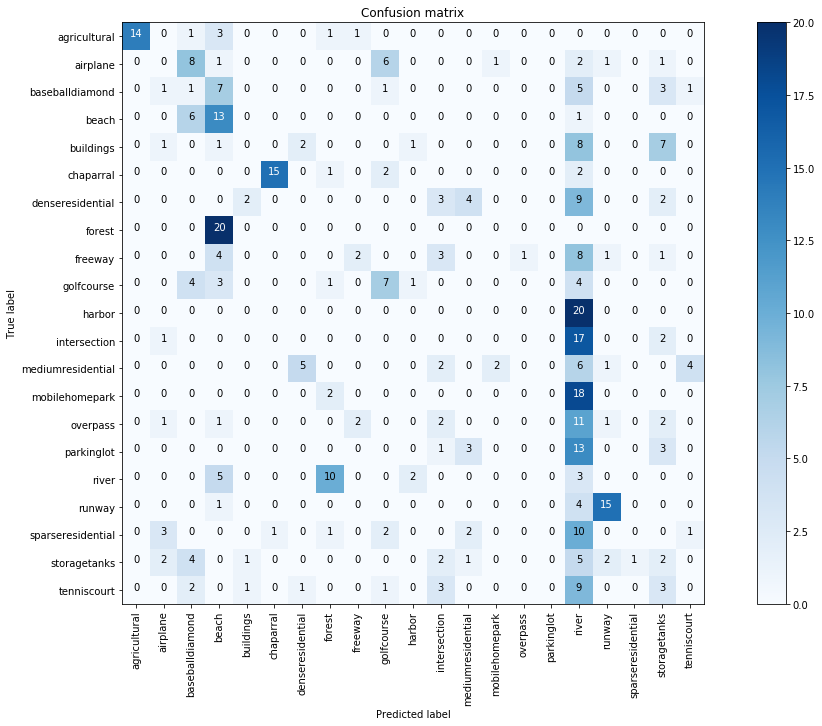

In [29]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2RepeatedAdditiveGaussianNoiseAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.7112171649932861


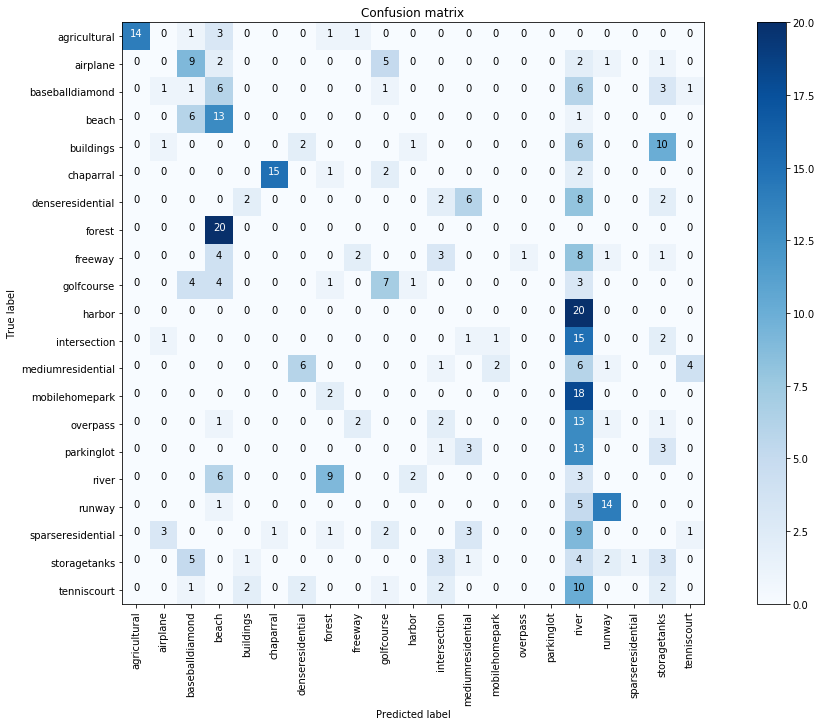

In [30]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2RepeatedAdditiveUniformNoiseAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 
labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.7207637131214142


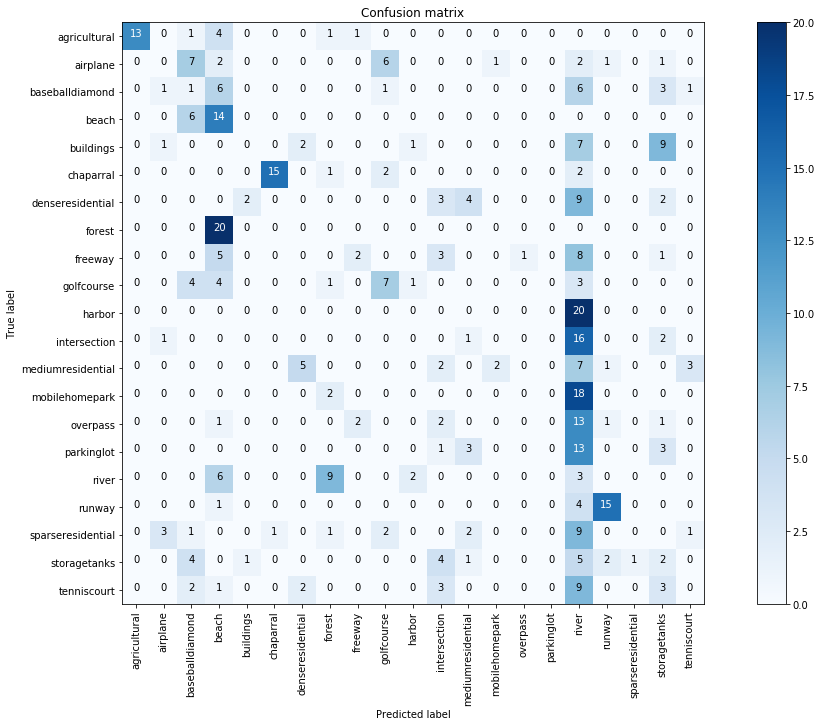

In [31]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2ClippingAwareRepeatedAdditiveGaussianNoiseAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.7159904539585114


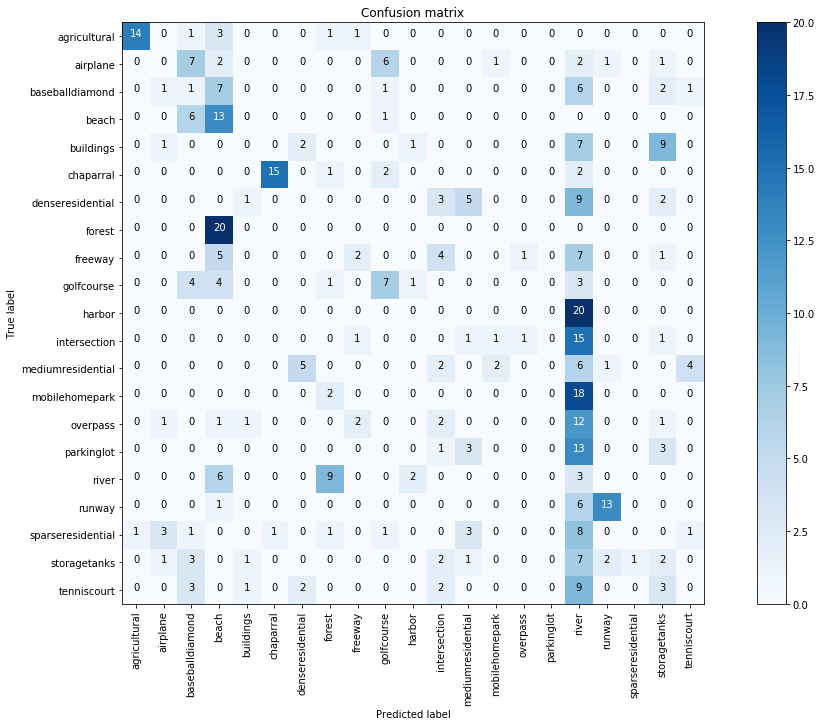

In [32]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2ClippingAwareRepeatedAdditiveUniformNoiseAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.2887827754020691


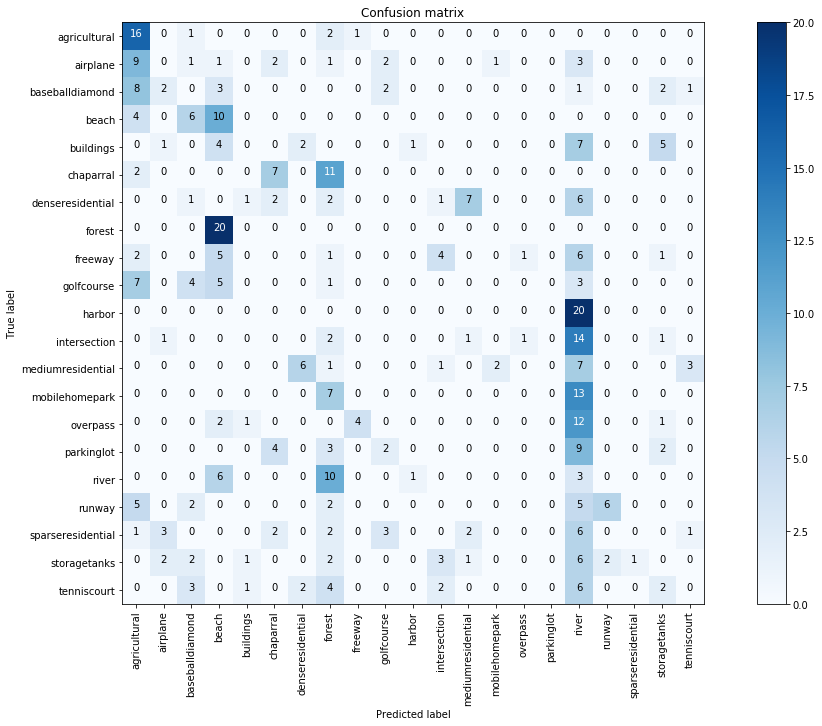

In [33]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfRepeatedAdditiveUniformNoiseAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 
labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.7231503427028656


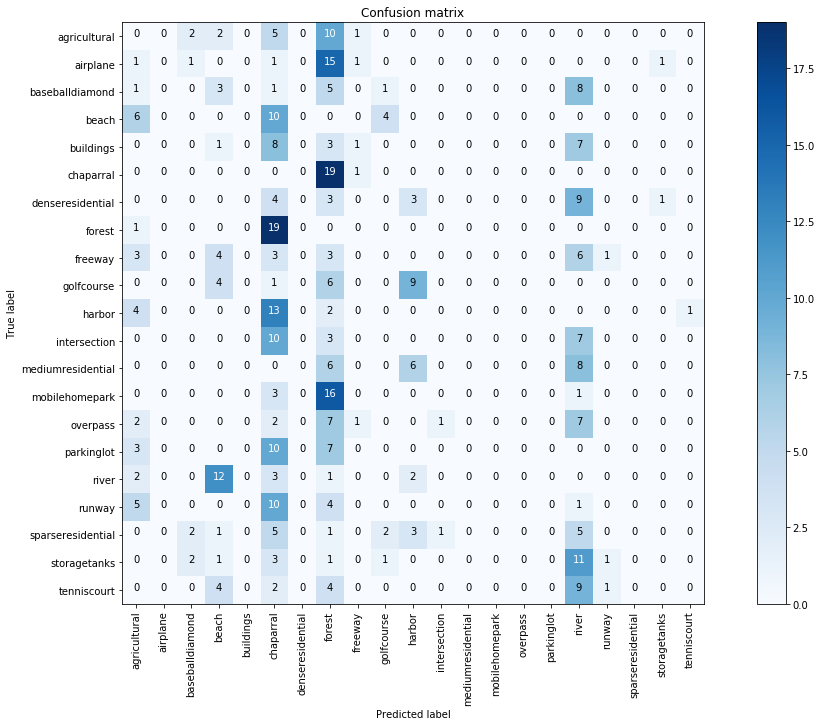

In [34]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.NewtonFoolAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))



labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.30071598291397095


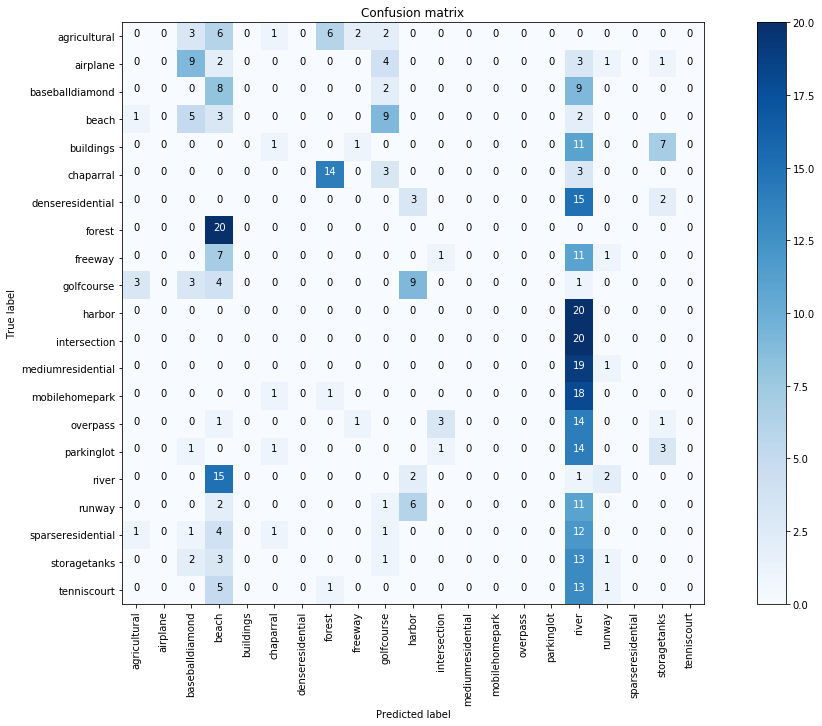

In [35]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfDeepFoolAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.7207637131214142


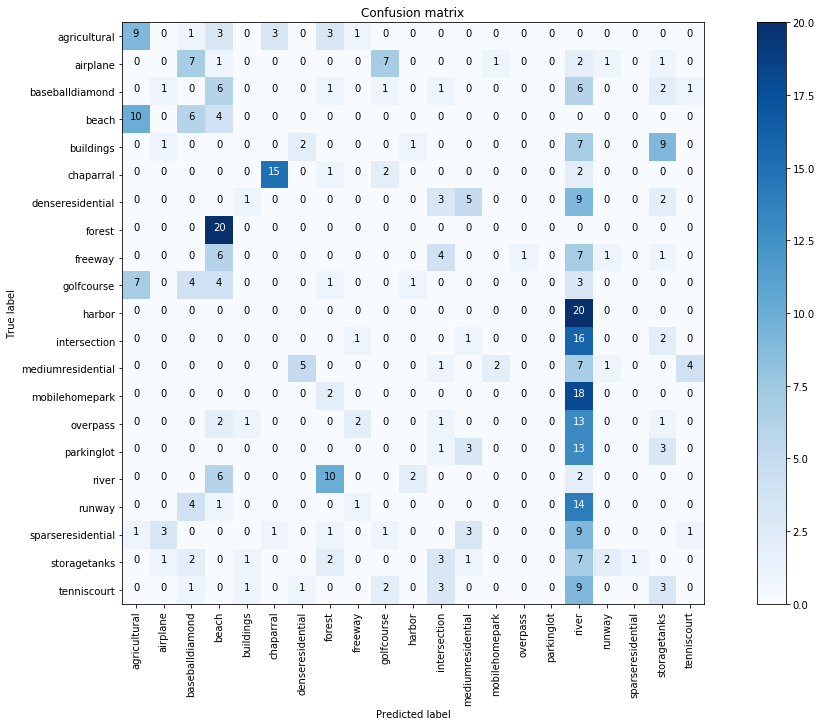

In [36]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.SaltAndPepperNoiseAttack()  

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.7231503427028656


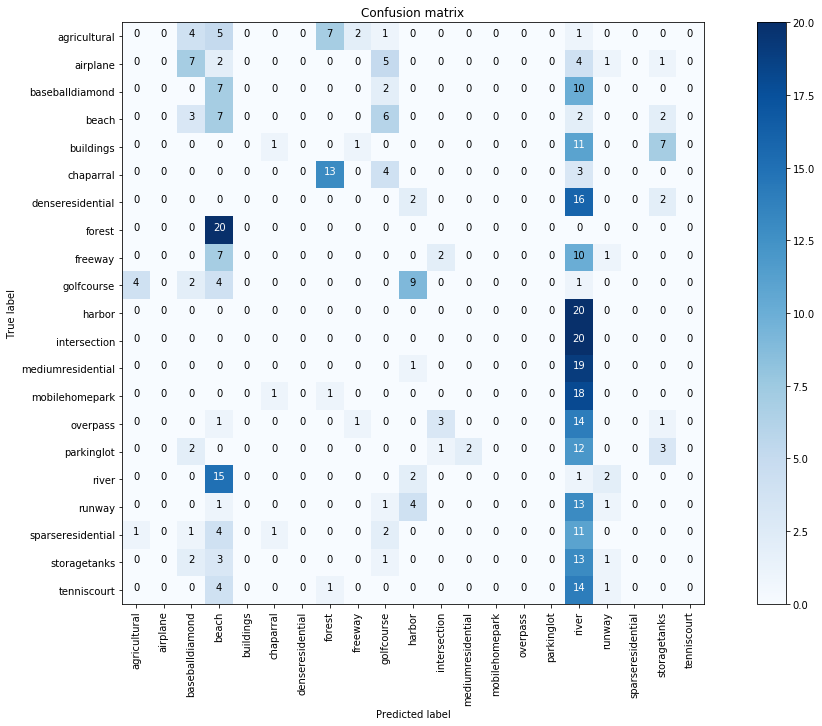

In [37]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2DeepFoolAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)


0.7183770835399628


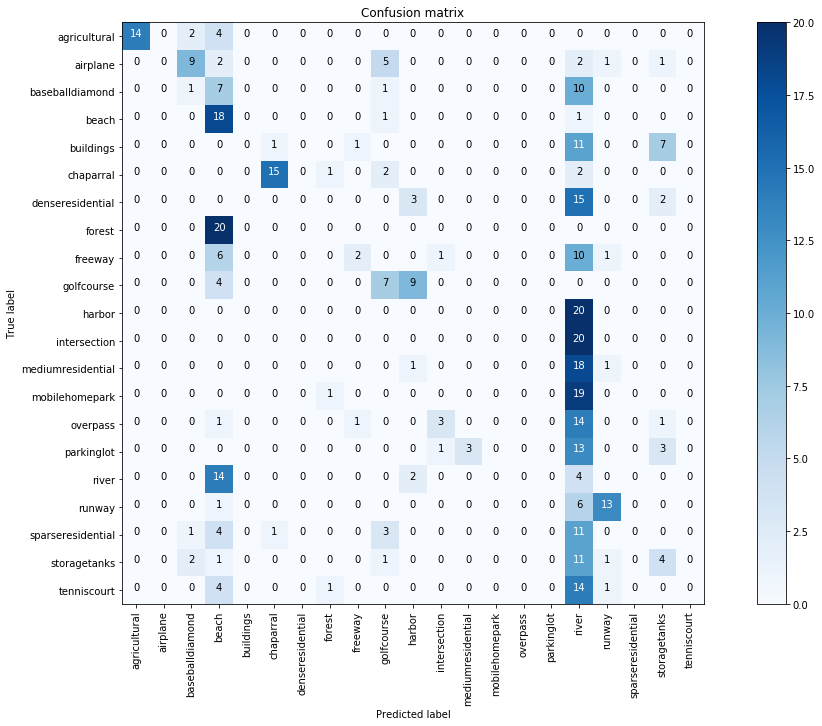

In [38]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2AdditiveGaussianNoiseAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))



labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.7159904539585114


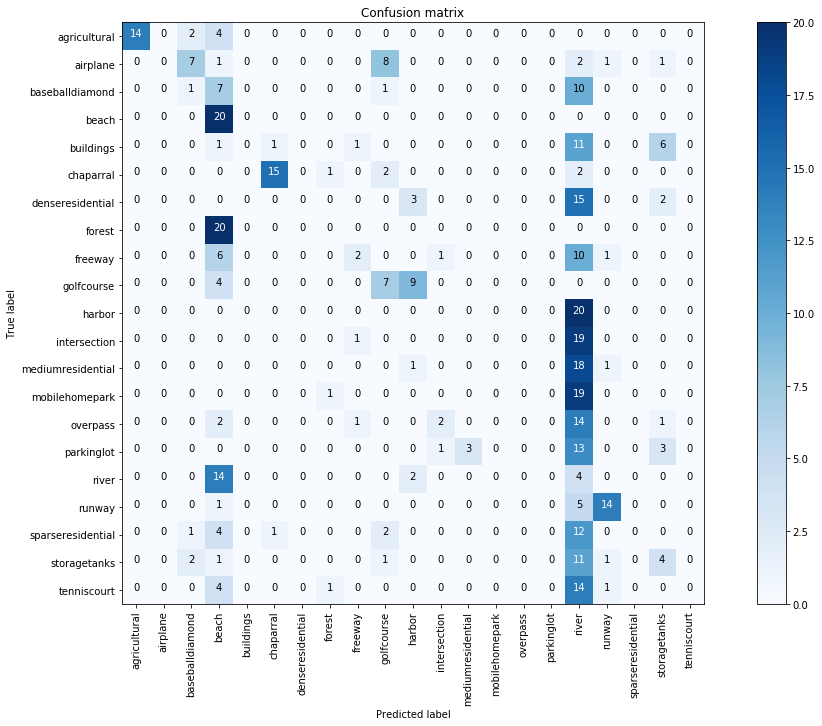

In [39]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2AdditiveUniformNoiseAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

 
labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.725536972284317


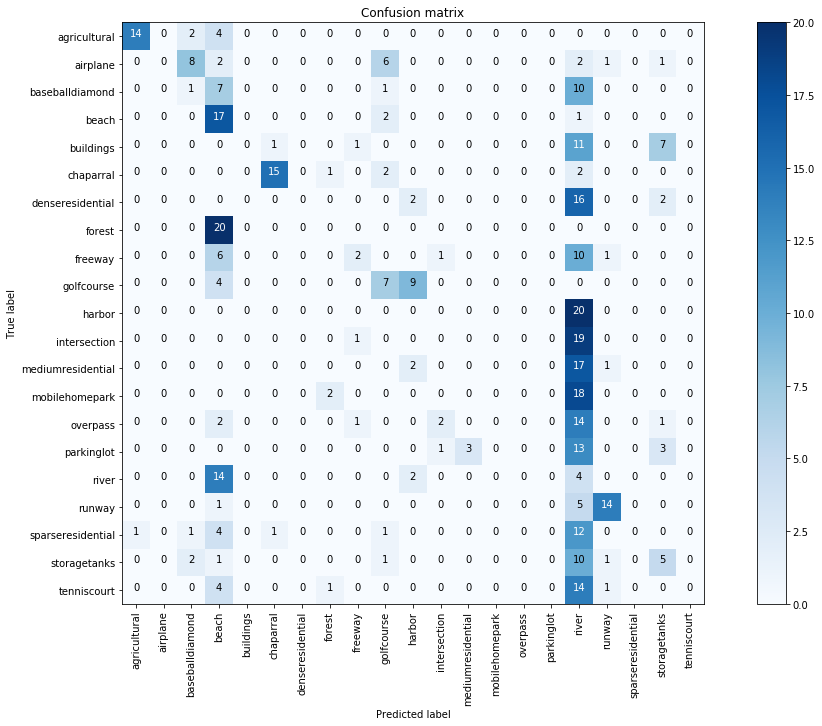

In [40]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2ClippingAwareAdditiveGaussianNoiseAttack()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.7136037945747375


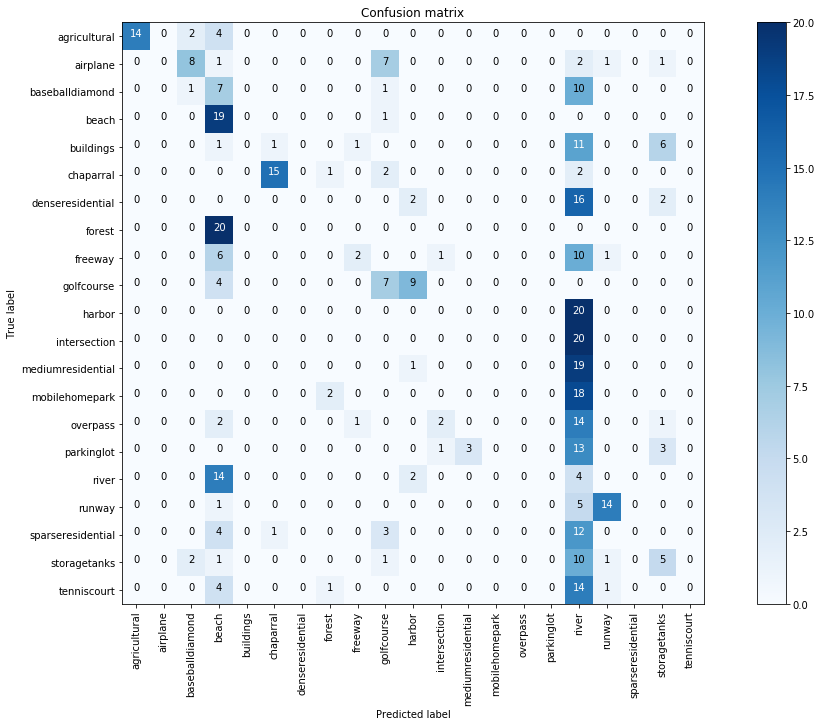

In [41]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2ClippingAwareAdditiveUniformNoiseAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.33174222707748413


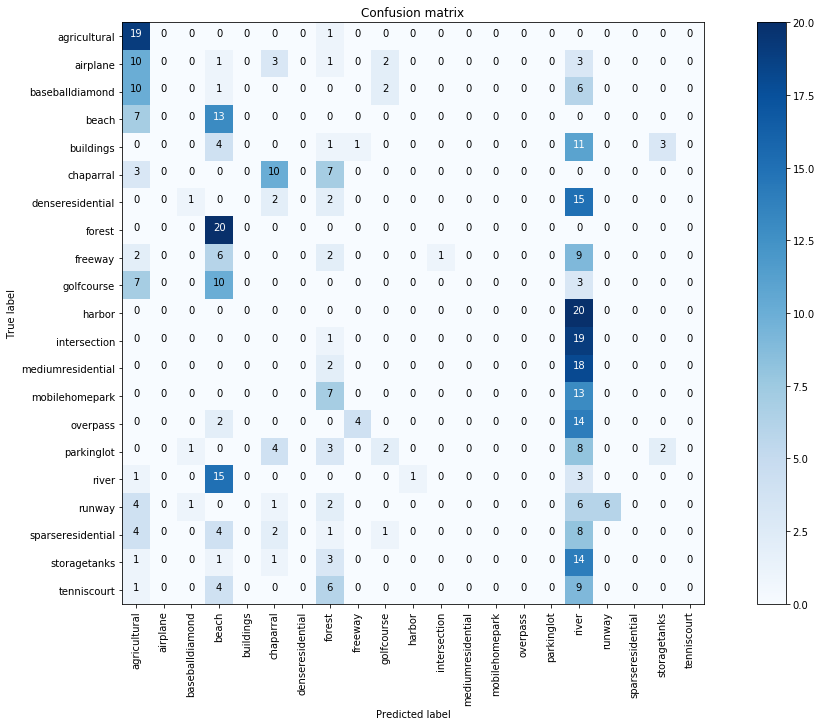

In [42]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfAdditiveUniformNoiseAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.7207637131214142


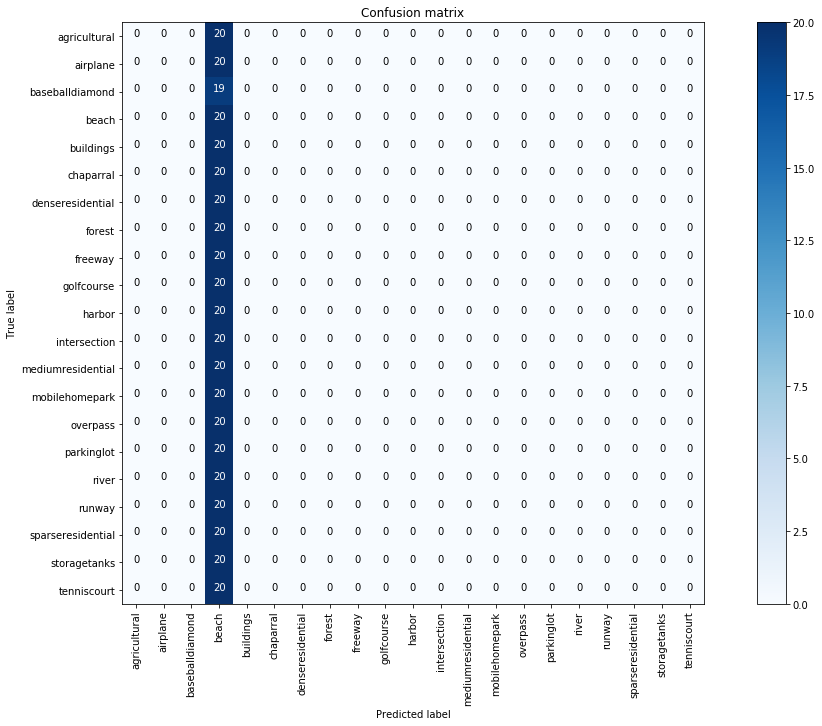

In [43]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2CarliniWagnerAttack()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.7159904539585114


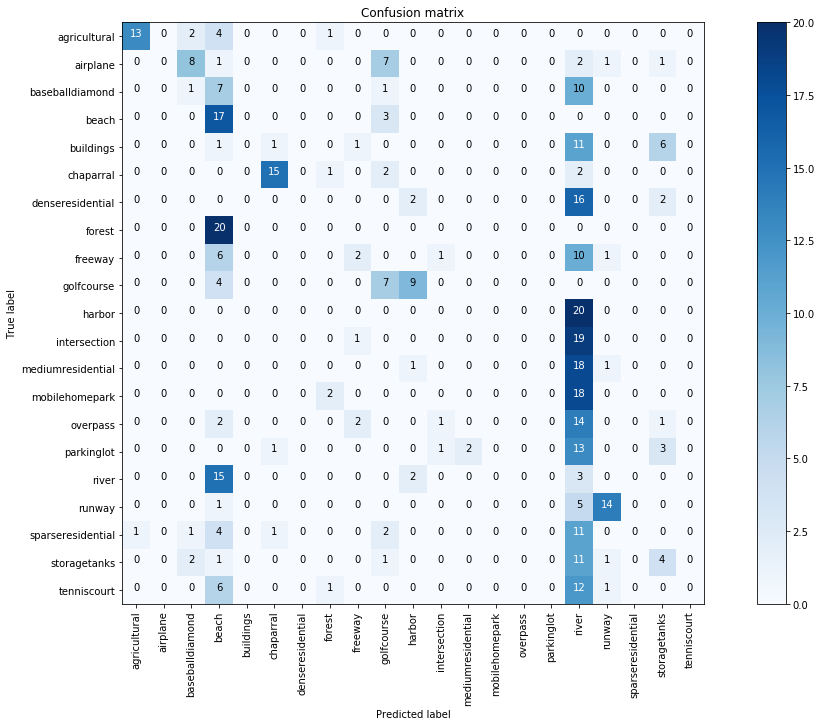

In [44]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.FGM()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))


labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.14081144332885742


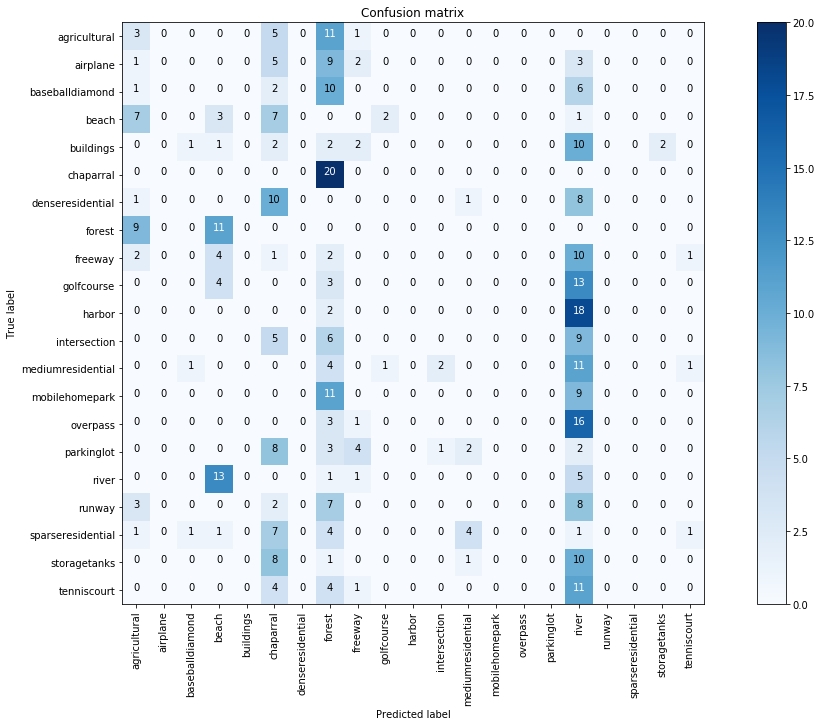

In [45]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.FGSM()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.7183770835399628


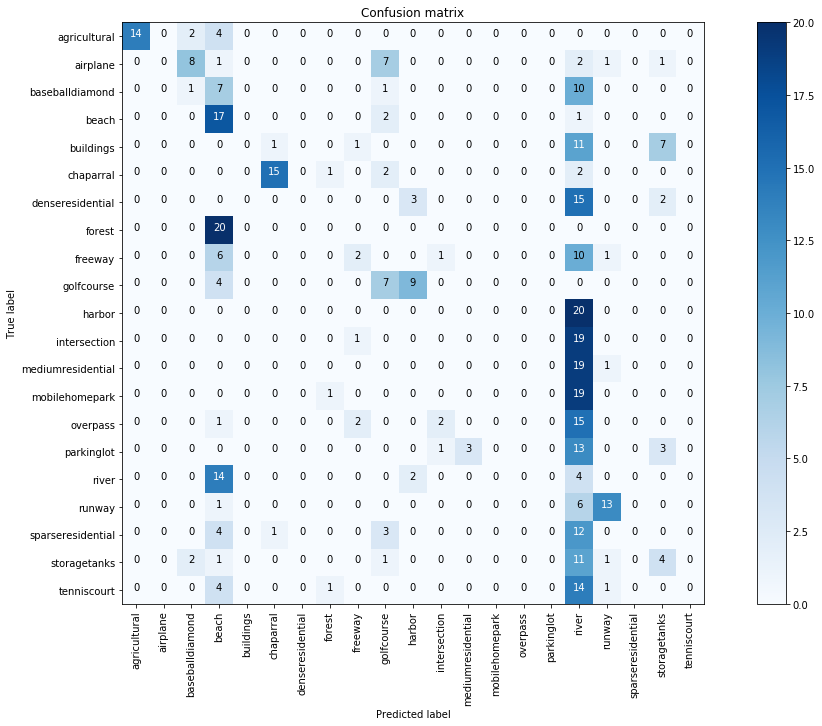

In [46]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.L2PGD()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  
labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.09785199165344238


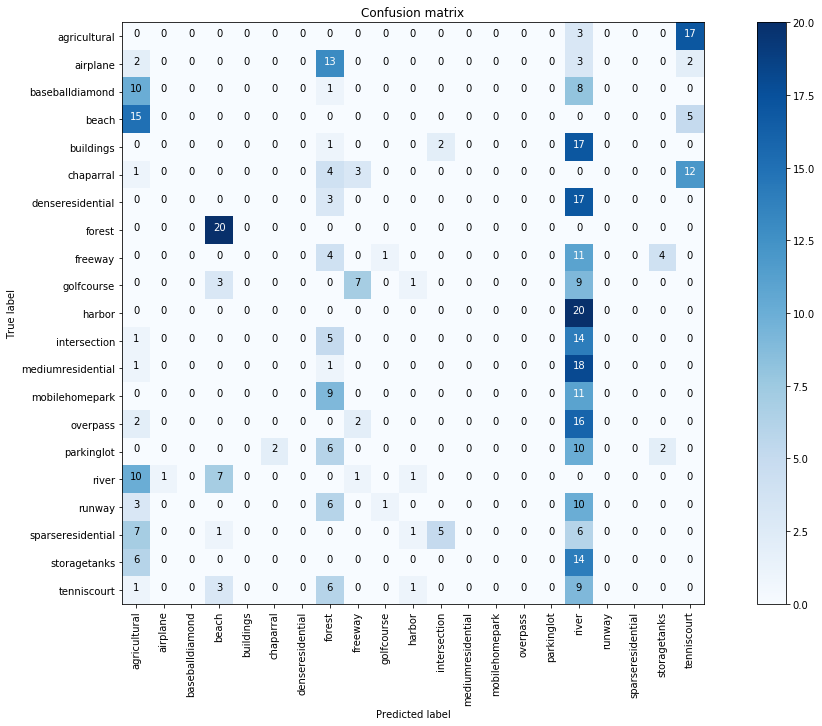

In [47]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.LinfPGD()
labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))

  

labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)

0.10262525081634521


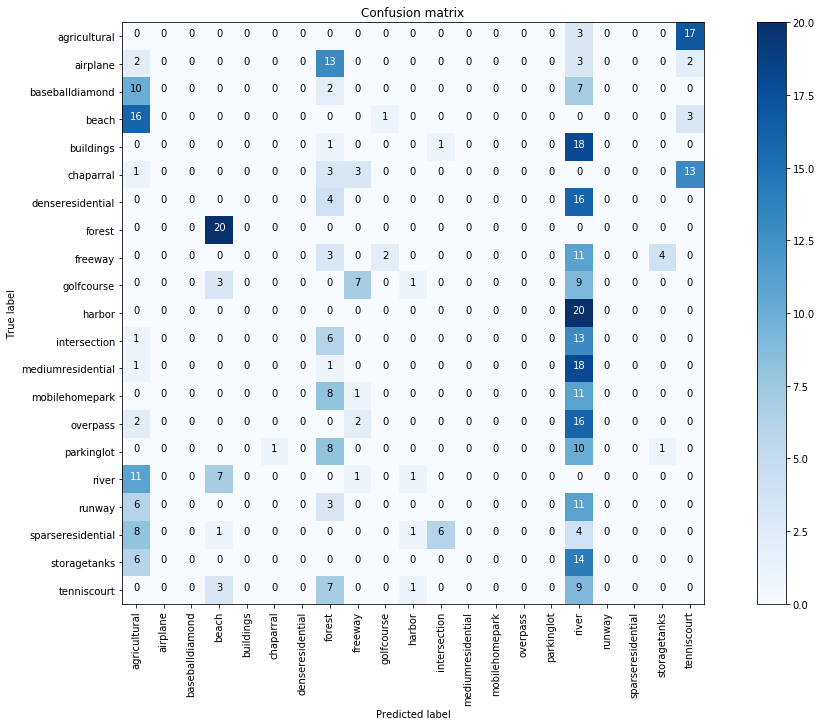

In [48]:
import eagerpy as ep
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

attack=foolbox.attacks.PGD()

labels_cat=torch.tensor([],device='cuda')
preds_cat=torch.tensor([],device='cuda')
is_adv_cat=torch.tensor([],device='cuda')

cnt=0
for images, labels in valid_loader:
  images = images.cuda()
  labels = labels.cuda()

  images = ep.astensor(images)
  labels = ep.astensor(labels)
  raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=1)
  
  is_adv=is_adv.raw
  images=images.raw
  labels=labels.raw
  raw=raw.raw 
  outputs = model(raw)
  _, preds = torch.max(outputs, 1)   

  labels_cat=torch.cat((labels_cat,labels))
  preds_cat=torch.cat((preds_cat,preds))
  is_adv_cat=torch.cat((is_adv_cat,is_adv))



labels_cat=labels_cat.cpu()
preds_cat=preds_cat.cpu()
cm = confusion_matrix(labels_cat,preds_cat) 

is_adv_cat=ep.astensor(is_adv_cat)    
print(1-is_adv_cat.float32().mean().item())
plt.figure(figsize=(15,10))
plot_confusion_matrix(cm, classes)